In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table

In [8]:
extended_exposure_table = Table.read('extended_exposure_data.ecsv').to_pandas()
no_wind_speed = extended_exposure_table['WIND_SPEED_AVG']<1E-5
ii = ~(no_wind_speed)
data = extended_exposure_table[ii]

In [10]:
# Create a copy of the data first to avoid chained indexing
data = data.copy()

# Clean data by dropping NaN values first
data = data.dropna()

# Create new columns using .loc
data.loc[:, 'WIND_EVENT'] = data['WIND_SHAKE_SUM'] + data['WIND_GUST_SUM']
data.loc[:, 'RANDOM_VAR'] = np.random.random(len(data))
data.loc[:, 'WIND_EVENT_BINARY'] = (data['WIND_EVENT'] > 0).astype(int)

# Select features (excluding WIND_EVENT, WIND_SHAKE_SUM, WIND_GUST_SUM, and target)
feature_cols = [col for col in data.columns if col not in ['WIND_EVENT', 'WIND_SHAKE_SUM', 
                                                         'WIND_GUST_SUM', 'WIND_EVENT_BINARY', 
                                                         'TIMESTAMP', 'SURVEY', 'PROGRAM']]

# Create feature matrix and target vector
X = data[feature_cols]
y = data['WIND_EVENT_BINARY']

# Print information about the dataset
print(f"Dataset size: {len(X)}")


Feature Importance Rankings:
GUST_STD: 0.1533
WIND_OPENING_ANGLE: 0.1328
GUST_AVG: 0.1213
WIND_DIRECTION_AVG: 0.1092
WIND_SPEED_STD: 0.1055
WIND_SPEED_AVG: 0.0823
MOUNT_AZ: 0.0624
WIND_DIRECTION_STD: 0.0474
MJD: 0.0425
EXPID: 0.0410
MOUNT_EL: 0.0394
EXPTIME: 0.0360
RANDOM_VAR: 0.0268


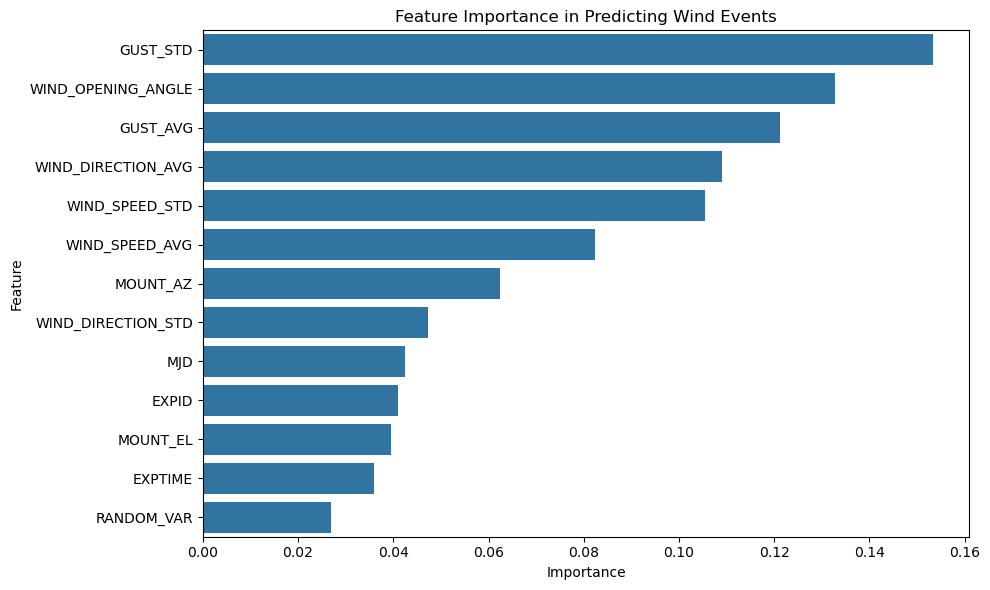

In [19]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X_train, y_train)

# Get feature importance
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance in Predicting Wind Events')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

plt.savefig('feature_importance.jpg',bbox_inches='tight')

# Print the feature importance values
print("\nFeature Importance Rankings:")
for idx, row in importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")